In [2]:
# Import required libraries
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import community as community_louvain
import matplotlib.gridspec as gridspec
import random
from networkx.algorithms import community
from collections import Counter
from prettytable import PrettyTable
from collections import defaultdict
# 10s

In [4]:
# --- 1. Load Data and Build Basic Graph ---

# Defining the file path of the dataset
file_path = "filtered_edges2.txt"

G = nx.DiGraph()

# Read the file line by line and add edges to the graph
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith("#"):
            continue
        
        parts = line.strip().split()
        if len(parts) != 3:
            continue
        
        try:
            source, target, sign = int(parts[0]), int(parts[1]), int(parts[2])
            G.add_edge(source, target, sign=sign)
        except ValueError:
            continue

print("--- Graph Statistics ---")
print(f"Number of nodes (people): {G.number_of_nodes()}")
print(f"Number of edges (relationships): {G.number_of_edges()}")

#Count positive and negative edges.
positive_edges = sum(1 for _, _, d in G.edges(data=True) if d.get('sign') == 1)
negative_edges = G.number_of_edges() - positive_edges

print(f"Friendship ties (sign=1): {positive_edges}")
print(f"Hostility ties (sign=-1): {negative_edges}")
print("-" * 40 + "\n")


--- Graph Statistics ---
Number of nodes (people): 10044
Number of edges (relationships): 28305
Friendship ties (sign=1): 21997
Hostility ties (sign=-1): 6308
----------------------------------------



C:\Users\insif\AppData\Local\Temp\ipykernel_23976\458312076.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Type', y='Count', data=edge_counts, palette=['green', 'red'])


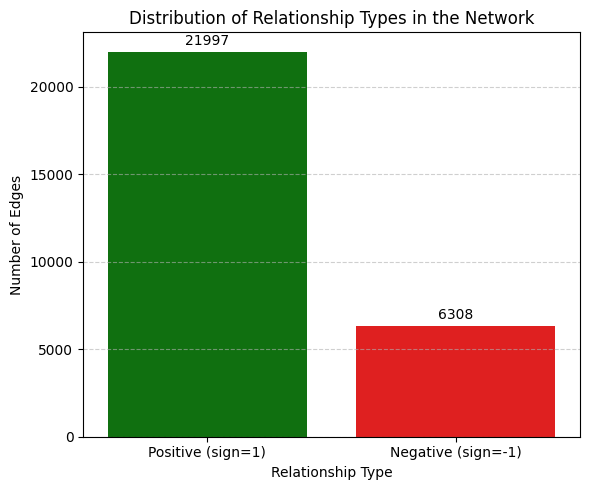

In [5]:
# --- 1. Calculate and Print Graph Statistics ---

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

positive_edges = sum(1 for _, _, d in G.edges(data=True) if d.get('sign') == 1)
negative_edges = num_edges - positive_edges  # sign is assumed to be only 1 or -1


# --- 2. Show Statistics as a Table ---

df_stats = pd.DataFrame({
    'Statistic': ['Number of Nodes', 'Number of Edges', 'Number of Positive Edges', 'Number of Negative Edges'],
    'Value': [num_nodes, num_edges, positive_edges, negative_edges]
})

# Version compatible and simple form
display(df_stats.style.set_properties(**{'text-align': 'left'}))


# --- 3. Bar Chart of Positive & Negative Edge Distribution ---

edge_counts = pd.DataFrame({
    'Type': ['Positive (sign=1)', 'Negative (sign=-1)'],
    'Count': [positive_edges, negative_edges]
})

plt.figure(figsize=(6, 5))
sns.barplot(x='Type', y='Count', data=edge_counts, palette=['green', 'red'])

# Write numbers on the bars
for i, row in edge_counts.iterrows():
    plt.text(i, row['Count'] + max(edge_counts['Count']) * 0.01, str(row['Count']),
             ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Relationship Types in the Network')
plt.ylabel('Number of Edges')
plt.xlabel('Relationship Type')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Dataset Size:** 10,044 individuals with a total of 28,305 directed connections representing either friendship or hostility.

* **21,997** of the connections are friendships (+1), while the remaining **6,308** are hostile ties (−1).

**Data Type:** A signed and directed graph, meaning the relationships between individuals are directional and can be either positive or negative.

**Relationship Types:** There are two types of edges: positive (friendship, +1) and negative (hostility, −1).

**Data Source:** [https://snap.stanford.edu/data/soc-sign-Slashdot081106.html](https://snap.stanford.edu/data/soc-sign-Slashdot081106.html)


C:\Users\insif\AppData\Local\Temp\ipykernel_23976\1781184239.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


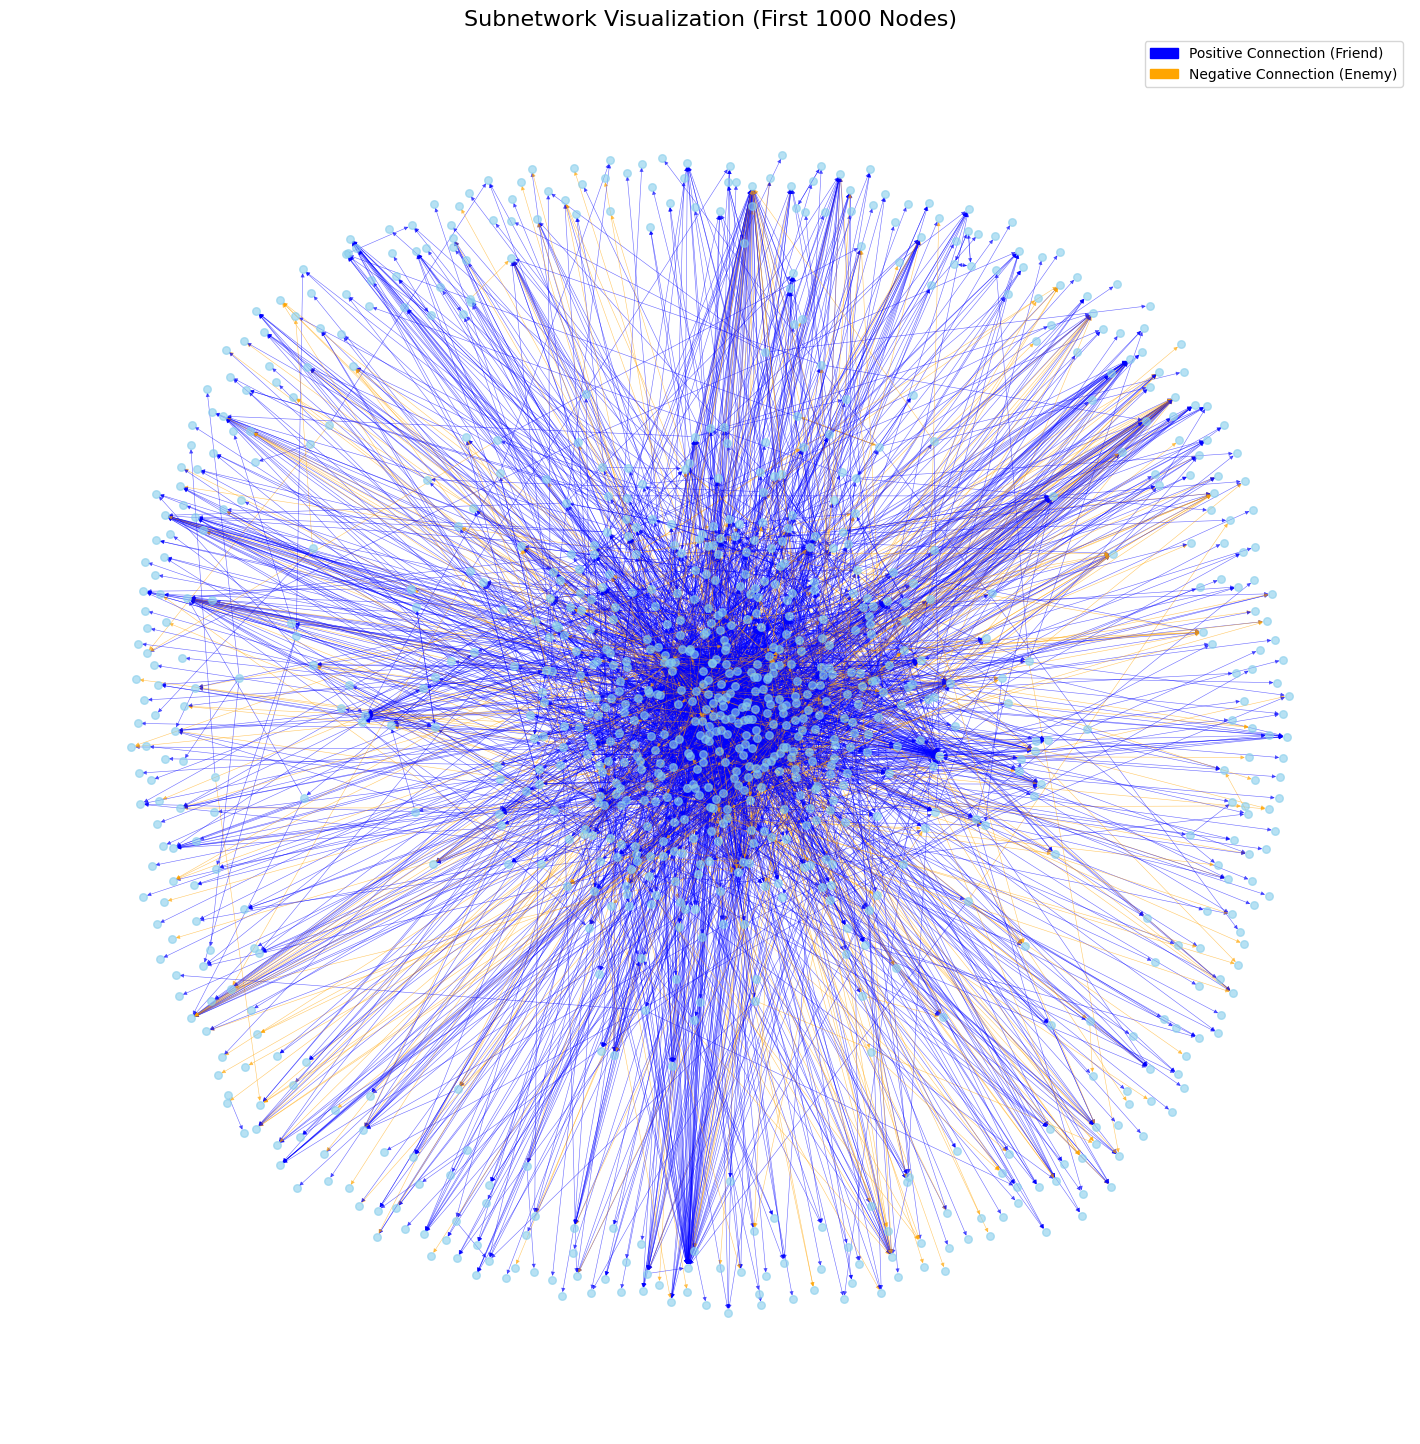

In [ ]:
# --- 2. Subnetwork Visualization ---

import matplotlib.patches as mpatches

# Determine the number of nodes to visualize in the subnetwork
num_nodes_to_visualize = min(1000, G.number_of_nodes())
sub_nodes = list(G.nodes())[:num_nodes_to_visualize]
subG = G.subgraph(sub_nodes).copy()  # Use .copy() to break external dependencies of the subgraph

# Determine edge colors based on the 'sign' value
edge_colors = [
    'blue' if subG[u][v].get('sign', 1) == 1 else 'orange'
    for u, v in subG.edges()
]

# Positioning algorithm (Spring layout)
pos = nx.spring_layout(subG, seed=42, k=0.1)

plt.figure(figsize=(14, 14))  # Large but not excessive

# Network drawing
nx.draw(
    subG, pos,
    with_labels=False,
    node_size=30,
    node_color='skyblue',
    edge_color=edge_colors,
    alpha=0.6,
    width=0.4,
    arrows=True,
    arrowsize=6
)

# Legend for edge colors
legend_handles = [
    mpatches.Patch(color='blue', label='Positive Connection (Friend)'),
    mpatches.Patch(color='orange', label='Negative Connection (Enemy)')
]
plt.legend(handles=legend_handles, loc='upper right', fontsize=10)

plt.title(f"Subnetwork Visualization (First {num_nodes_to_visualize} Nodes)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
#24s

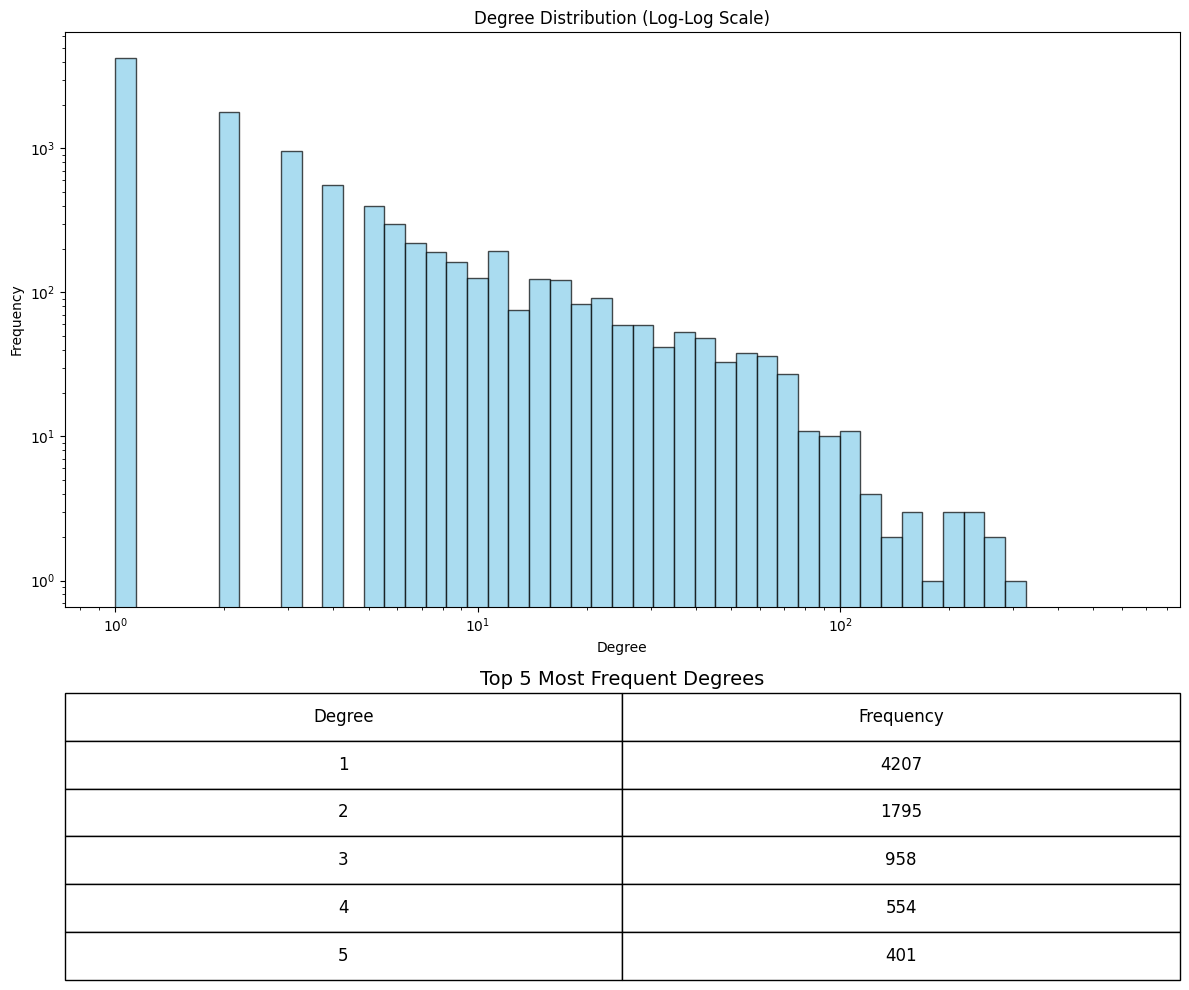

In [7]:
# --- 4. Degree Distribution Analysis (Histogram + Table) ---

from collections import Counter

# Total degree values (in-degree + out-degree for undirected graphs)
total_degrees = [d for _, d in G.degree()]

# Degree frequencies
degree_freq_df = (
    pd.DataFrame(Counter(total_degrees).items(), columns=["Degree", "Frequency"])
    .sort_values("Frequency", ascending=False)
    .reset_index(drop=True)
)

# Log-log histogram + table for visualization (first 25 degree values)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

# --- Histogram ---
ax1.hist(
    total_degrees,
    bins=np.logspace(np.log10(max(1, min(total_degrees))), np.log10(max(total_degrees)), 50),
    color='skyblue', edgecolor='black', alpha=0.7
)
ax1.set(xscale="log", yscale="log", xlabel="Degree", ylabel="Frequency", title="Degree Distribution (Log-Log Scale)")

# --- Table ---
ax2.axis('off')
table = ax2.table(
    cellText=degree_freq_df.head(5).values,
    colLabels=degree_freq_df.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.2)
ax2.set_title("Top 5 Most Frequent Degrees", fontsize=14)

plt.tight_layout()
plt.show()

### <h3>The chart above indicates the following:</h3>

Considering there are a total of 10,044 individuals in the network, we can say that more than half of them are relatively isolated.

* **4,207 nodes** have only **1 connection**.
* **1,795 nodes** have just **2 connections**.
* **958 nodes** have a total of **3 connections**.

**This indicates that:**
There are many low-degree nodes in the network, meaning most individuals have interacted with only a small number of others.


# 2. Basic Network Metrics

--- Basic Network Metrics ---
Average In-Degree  : 2.82
Average Out-Degree : 2.82
Average Total Degree : 5.64


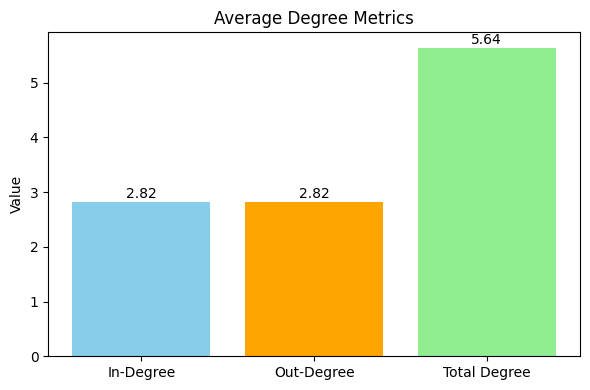

In [8]:
# --- 2. Basic Network Metrics Calculations ---
print("--- Basic Network Metrics ---")

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_degree = num_edges / num_nodes  # In directed graphs, the average in-degree and out-degree are the same

print(f"Average In-Degree  : {avg_degree:.2f}")
print(f"Average Out-Degree : {avg_degree:.2f}")

# Average of the total (in + out) degree
avg_total_degree = np.mean([deg for _, deg in G.degree()])
print(f"Average Total Degree : {avg_total_degree:.2f}")


# Visualization
plt.figure(figsize=(6, 4))

bars = plt.bar(
    ['In-Degree', 'Out-Degree', 'Total Degree'],
    [avg_degree, avg_degree, avg_total_degree],
    color=['skyblue', 'orange', 'lightgreen']
)

plt.title("Average Degree Metrics")
plt.ylabel("Value")

# Add value labels on top of the bars
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, y + 0.02, f"{y:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Average degree** is a fundamental network statistic that indicates how many connections (edges) a node has on average in a graph. It provides a rough understanding of how connected the network is overall.


--- Reciprocity ---
Overall Reciprocity Ratio: 0.174


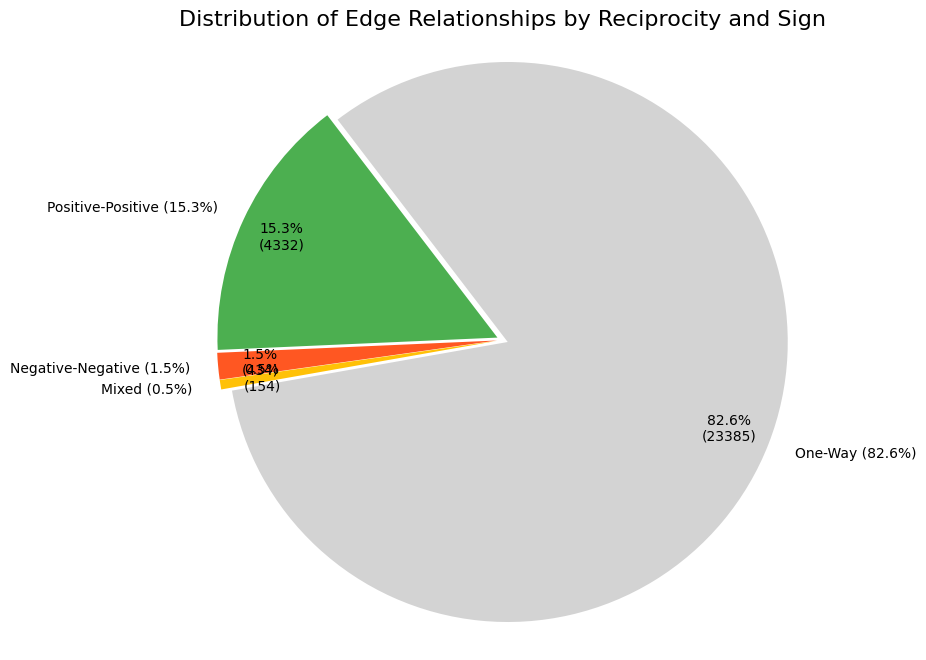

In [9]:
# --- 2.7. Reciprocity ---
print("--- Reciprocity ---")

reciprocity = nx.reciprocity(G)
print(f"Overall Reciprocity Ratio: {reciprocity:.3f}")

# Separation of reciprocal relationships by sign type
pp, nn, mixed, one_way = 0, 0, 0, 0
seen = set()

for u, v, d in G.edges(data=True):
    if (u, v) in seen or (v, u) in seen:
        continue

    sign_uv = d.get('sign', 1)
    if G.has_edge(v, u):
        sign_vu = G[v][u].get('sign', 1)
        if sign_uv == sign_vu == 1:
            pp += 1
        elif sign_uv == sign_vu == -1:
            nn += 1
        else:
            mixed += 1
        seen.update([(u, v), (v, u)])
    else:
        one_way += 1
        seen.add((u, v))

# Each reciprocal pair has 2 edges
tot_edges = G.number_of_edges()
tot_reciprocal = 2 * (pp + nn + mixed)
sizes = [one_way, 2 * pp, 2 * nn, 2 * mixed]
counts = [one_way, 2 * pp, 2 * nn, 2 * mixed]
labels = [
    f'One-Way ({one_way / tot_edges * 100:.1f}%)',
    f'Positive-Positive ({2 * pp / tot_edges * 100:.1f}%)',
    f'Negative-Negative ({2 * nn / tot_edges * 100:.1f}%)',
    f'Mixed ({2 * mixed / tot_edges * 100:.1f}%)'
]
colors = ['#D3D3D3', '#4CAF50', '#FF5722', '#FFC107']

# 🔧 Let's set the autopct format to show both percentage and count
def format_label(pct, allvals):
    total = sum(allvals)
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct=lambda pct: format_label(pct, sizes),
    startangle=190,
    pctdistance=0.85,
    explode=[0.02] * 4
)
plt.title("Distribution of Edge Relationships by Reciprocity and Sign", fontsize=16)
plt.axis('equal')
plt.show()

| **Metric**              | **Description**                                                                                                                                                                                                                                        |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Overall Reciprocity** | 🔹 This ratio indicates how many of the edges in the network are bidirectional. In other words, if both (u → v) and (v → u) edges exist, it is considered a reciprocal relationship.                                                                   |
| **17.4%**               | 🔹 Only about 17% of the edges in the network are reciprocal. This suggests that the vast majority of interactions in the network are **one-way**. In networks such as social media, where follow-unfollow dynamics exist, this ratio tends to be low. |



--- Connected Components Analysis ---
Number of Weak Components : 323
Largest WCC Node Count  : 9340 (92.99%)
Number of Strong Components : 7557
Largest SCC Node Count  : 2204


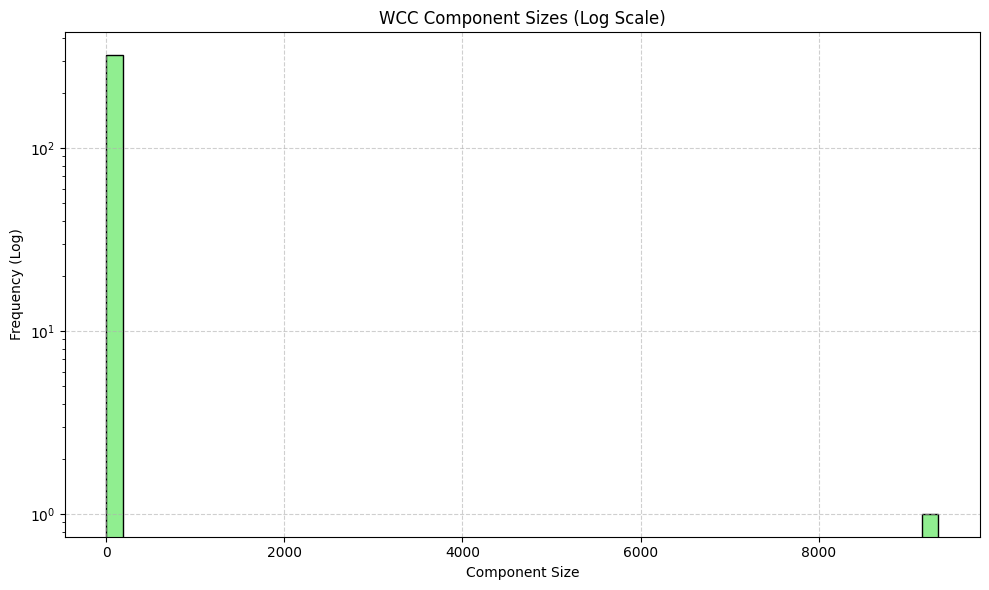

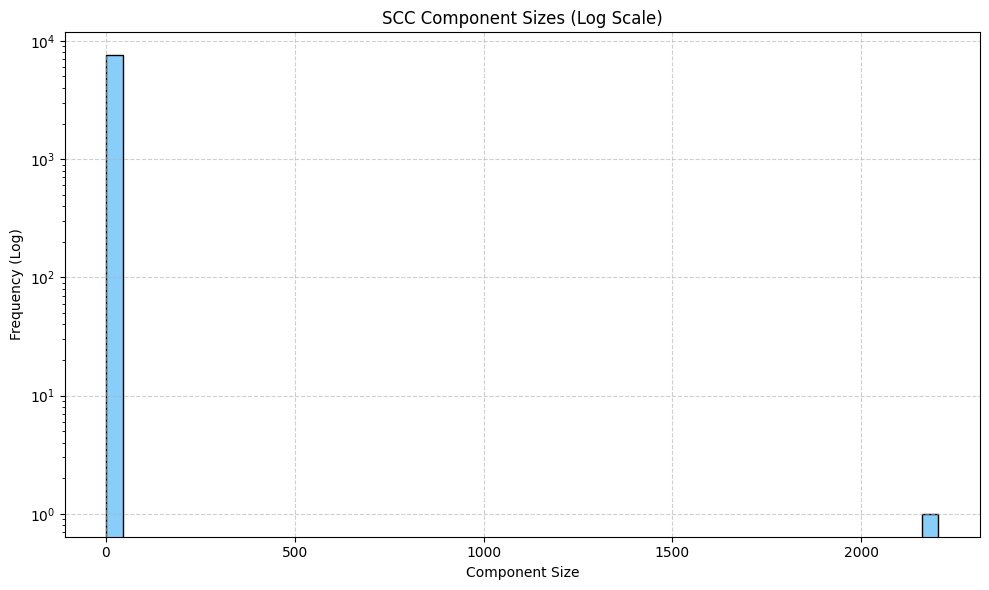

In [10]:
# --- Connected Components Analysis ---
print("\n--- Connected Components Analysis ---")

# WCC (Weakly Connected Components)
wcc = list(nx.weakly_connected_components(G))
largest_wcc = max(wcc, key=len)
G_wcc = G.subgraph(largest_wcc).copy()
G_undirected = G_wcc.to_undirected()

print(f"Number of Weak Components : {len(wcc)}")
print(f"Largest WCC Node Count  : {len(largest_wcc)} ({len(largest_wcc) / G.number_of_nodes() * 100:.2f}%)")

# SCC (Strongly Connected Components)
scc = list(nx.strongly_connected_components(G))
largest_scc = max(scc, key=len) if scc else set()

print(f"Number of Strong Components : {len(scc)}")
print(f"Largest SCC Node Count  : {len(largest_scc)}")

# --- Histogram of WCC Size Distribution ---
wcc_sizes = [len(c) for c in wcc]

plt.figure(figsize=(10, 6))
plt.hist(wcc_sizes, bins=50, color='lightgreen', edgecolor='black', log=True)
plt.title("WCC Component Sizes (Log Scale)")
plt.xlabel("Component Size")
plt.ylabel("Frequency (Log)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Histogram of SCC Size Distribution ---
scc_sizes = [len(c) for c in scc]

plt.figure(figsize=(10, 6))
plt.hist(scc_sizes, bins=50, color='lightskyblue', edgecolor='black', log=True)
plt.title("SCC Component Sizes (Log Scale)")
plt.xlabel("Component Size")
plt.ylabel("Frequency (Log)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

| Ölçüm Türü                     | Değer | Açıklama                                                                                                                                                                                       |
| ------------------------------ | ----- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Weakly Connected Components (WCC) Count** | 323   | 🔹 A weakly connected component is a subnetwork where all nodes are connected if we ignore the direction of the edges. The network has a total of 323 weakly connected components.                               |
| **Largest WCC Size**        | 9340  | 🔹 The largest weakly connected component consists of 9340 nodes. This indicates that a large portion of the network (93%) is connected, even indirectly, when considering undirected connections. The majority of the network resides within this main component. |
| **Strongly Connected Components (SCC) Count** | 7557  | 🔹 Strongly connected components are subnetworks where every node can reach every other node **directionally**. A high number like 7557 suggests that the network is divided into many small, directed groups. |
| **Largest SCC Size**        | 2204  | 🔹 The largest component where directional reachability is possible contains 2204 nodes. This indicates a more fragmented structure compared to the WCC and highlights the significant role of edge directions in the network's connectivity.                     |


**Weakly Connected Components:** A group of nodes where any node can reach any other node if the direction of the edges is ignored.

**Strongly Connected Components:** A group of nodes where every node can reach every other node by following directed paths.

📌 Comments
+ The fact that the network is largely connected (93%) when made undirected indicates that the network is structurally integrated, meaning that most components are connected to the main body.

+ However, when directed connections are considered (SCC), the network becomes much more fragmented. This suggests that most interactions within the network are one-way.

+ The largest SCC component consists of 2204 nodes, indicating that only a specific subset can engage in reciprocal interactions.

`largest_wcc = max(nx.weakly_connected_components(G), key=len)`
👉 In this line:

The `nx.weakly_connected_components(G)` function finds the weakly connected components in a directed network.

Weakly connected component = A set of nodes that are reachable from each other when the direction of the edges is ignored.

The `max(..., key=len)` part selects the largest of these components (i.e., the one containing the most nodes).

This way, when calculating the diameter of a fragmented network, only the significant large component is examined.

🔹 Summary: The largest weakly connected component (WCC) node set is obtained.


--- Average Path Length and Diameter ---
Calculating diameter...
Diameter: 12
Calculating average path length...
Average Path Length: 4.285

--- Clustering Coefficient Analysis ---


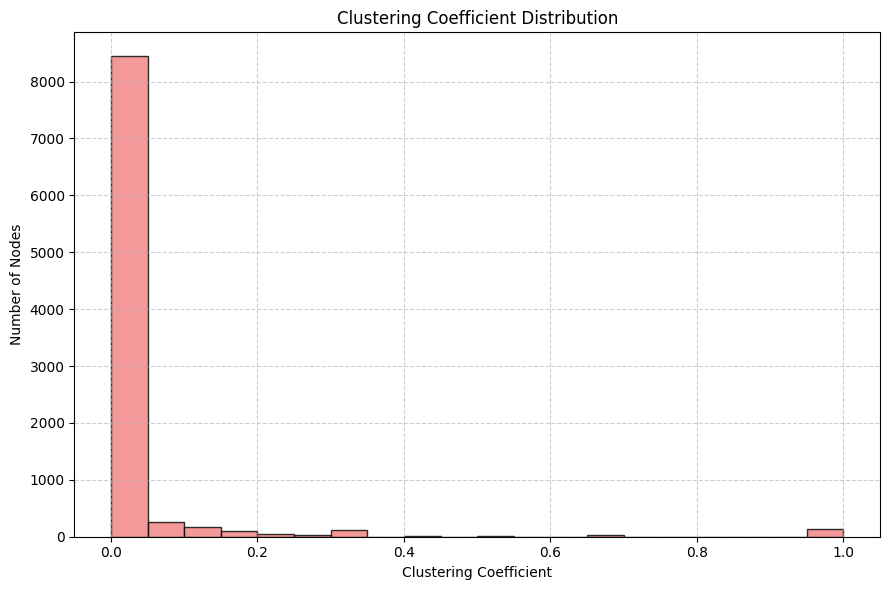

Clustering Coefficient Basic Statistics:
                     Value
Minimum             0.0000
Maximum             1.0000
Average             0.0315
Median              0.0000
Standard Deviation  0.1333


In [ ]:
# --- Average Path Length and Diameter ---
print("\n--- Average Path Length and Diameter ---")

diameter = avg_path_length = "Could not be calculated"

if G_undirected.number_of_nodes() <= 1:
    print("Warning: Component is empty or has a single node.")
elif not nx.is_connected(G_undirected):
    print("Warning: The undirected component is not connected. Diameter and path length cannot be calculated.")
else:
    try:
        print("Calculating diameter...")
        diameter = nx.diameter(G_undirected)
        print(f"Diameter: {diameter}")
    except Exception as e:
        print(f"Diameter error: {e}")

    try:
        print("Calculating average path length...")
        avg_path_length = nx.average_shortest_path_length(G_undirected)
        print(f"Average Path Length: {avg_path_length:.3f}")
    except Exception as e:
        print(f"Path length error: {e}")

# --- Clustering Coefficient Analysis ---
print("\n--- Clustering Coefficient Analysis ---")

clustering_values = list(nx.clustering(G_undirected).values())
avg_clustering = np.mean(clustering_values)

# Histogram
plt.figure(figsize=(9, 6))
plt.hist(clustering_values, bins=np.linspace(0, 1, 21), color='lightcoral', edgecolor='black', alpha=0.8)
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Number of Nodes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Basic statistics
clustering_stats_df = pd.DataFrame({
    "Value": [
        np.min(clustering_values),
        np.max(clustering_values),
        avg_clustering,
        np.median(clustering_values),
        np.std(clustering_values)
    ]
}, index=["Minimum", "Maximum", "Average", "Median", "Standard Deviation"])

print("Clustering Coefficient Basic Statistics:")
print(clustering_stats_df.round(4).to_string())

| Metric                   | Value | Description                                                                                                                                                                                                                                                                           |
| ------------------------ | ----- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Diameter**             | 12    | 🔹 The longest shortest path in the network is 12 steps. This is the maximum number of steps required for the most distant two nodes in the network to reach each other. A high diameter indicates that the network is wide and some nodes are positioned quite far from one another. |
| **Average Path Length**  | 4.285 | 🔹 The average shortest path between two randomly selected nodes in the network is approximately 4.29 steps. This indicates that the network has a moderately efficient structure for information dissemination.                                                                      |


| Statistic              | Value  | Description                                                                                                                                                                |
| ---------------------- | ------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Minimum**            | 0.0000 | 🔹 There are nodes with no connections among their neighbors. This indicates that some nodes are completely isolated in terms of local connectivity.                       |
| **Maximum**            | 1.0000 | 🔹 Some nodes exhibit full clustering where all of their neighbors are connected to each other. This represents the highest level of local density.                        |
| **Average**            | 0.0315 | 🔹 The overall clustering tendency in the network is quite low. This suggests that the network is generally loosely connected with low local density around most nodes.    |
| **Median**             | 0.0000 | 🔹 More than half of the nodes have a clustering coefficient of zero. In other words, most nodes are in a position where their neighbors are not connected to one another. |
| **Standard Deviation** | 0.1333 | 🔹 There is some variation in clustering among the nodes, but it is not very high. Although some areas are locally dense, clustering levels are generally similar overall. |


In [12]:
# --- 2.5. Density ---
print("--- Network Density ---")
density = nx.density(G)
print(f"Density (between 0 and 1): {density:.6f}")

# --- 2.6. Triangle Count ---
print("\n--- Triangle Count ---")
# nx.triangles() gives the number of triangles each node belongs to.
# Each triangle is counted 3 times (once for each node) → divide the sum by 3 to get the actual count.
triangle_count = sum(nx.triangles(G_undirected).values()) // 3
print(f"Total Number of Triangles: {triangle_count}")

--- Network Density ---
Density (between 0 and 1): 0.000281

--- Triangle Count ---
Total Number of Triangles: 7489


| Metric                  | Description                                                                                                                                                                                                                         |
| ----------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Number of Triangles** | 🔹 A triangle is a closed substructure where three nodes are directly connected to each other. It provides insights into local clustering and community density within the network.                                                 |
| **3434**                | 🔹 A total of 3434 triangles have been detected in the network. This indicates that nodes form tight connections within certain subgroups. Although the overall density is low, there may be clustering tendencies in some regions. |


İşte İngilizce çevirisi:

| Metric              | Description                                                                                                                                                                                                      |
| ------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Network Density** | 🔹 Density is the ratio of the number of existing edges in the network to the maximum possible number of edges. It ranges between 0 and 1.                                                                       |
| **0.000131**        | 🔹 This value indicates that the network is extremely sparsely connected. In other words, there are very few direct connections between nodes. Such low density is common in large-scale social or web networks. |

In [13]:
# --- 2.8. Degree Assortativity Coefficient ---
print("--- Degree Assortativity Coefficient ---")

# This coefficient measures the tendency of nodes with similar degrees to connect to each other
try:
    assortativity = nx.degree_pearson_correlation_coefficient(G)
    print(f"Assortativity (Pearson): {assortativity:.3f}")
except Exception as e:
    print(f"Calculation failed: {e}")

--- Degree Assortativity Coefficient ---
Assortativity (Pearson): -0.110


| Metric            | Description                                                                                                                                                                |
| ----------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Assortativity** | 🔹 This coefficient measures the correlation between the degrees of connected nodes. Its value ranges from -1 to +1.                                                       |
| **-0.110**        | 🔹 A slightly negative value. This indicates that low-degree nodes tend to connect with high-degree nodes. In other words, the network has a **disassortative** structure. |


İşte metnin İngilizce çevirisi:

📈 What Does It Mean?

* **Positive Assortativity (+)**
  → Nodes with similar degrees (e.g., high degree → high degree) tend to connect with each other. This is commonly observed in social networks.

* **Negative Assortativity (–)**
  → Low-degree nodes tend to connect with high-degree nodes. This structure is often found in hierarchical or centralized networks. For example:

  * Links between web pages
  * Information flow networks
  * Follower-based platforms

* **Close to 0**
  → Connections are random, with no clear preference.


--- Community Detection (Louvain) ---
Running Louvain...
Modularity (Community Quality): 0.510
Number of Communities      : 432
Largest Community Size     : 989 nodes
Smallest Community Size    : 2 nodes
Average Community Size     : 20.62


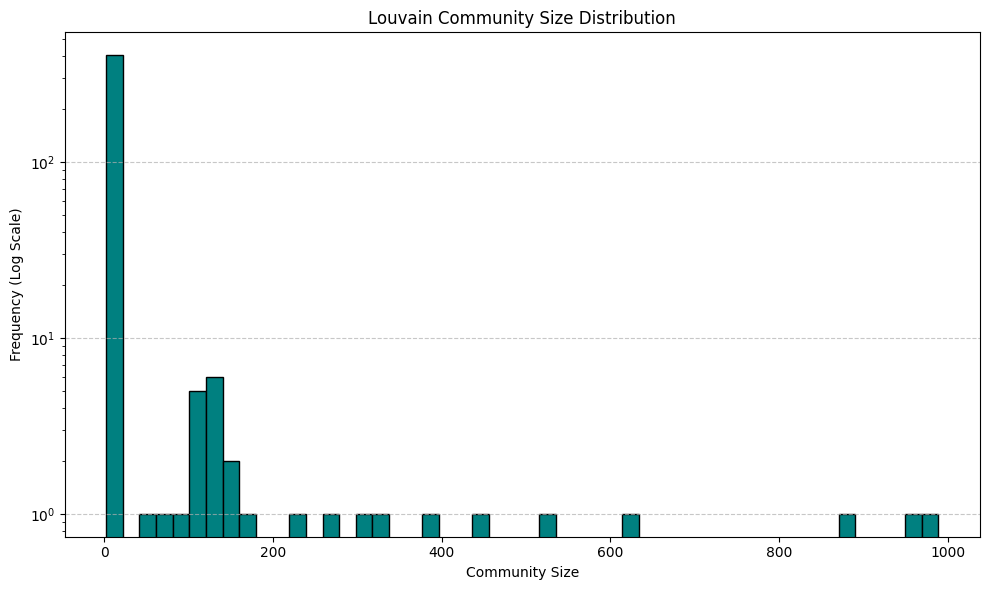

In [ ]:
# --- 3. Community Detection (Louvain Algorithm) ---
print("--- Community Detection (Louvain) ---")

# Create an undirected graph with only positive (friendship) edges
G_friend = nx.Graph((u, v) for u, v, d in G.edges(data=True) if d.get('sign') == 1)

if G_friend.number_of_nodes() == 0:
    print("The graph created with positive edges is empty. Louvain cannot be applied.")
    partition, modularity, community_sizes = {}, 0, []
else:
    from community import community_louvain
    from collections import defaultdict
    print("Running Louvain...")
    partition = community_louvain.best_partition(G_friend)
    modularity = community_louvain.modularity(partition, G_friend)
    print(f"Modularity (Community Quality): {modularity:.3f}")

    # Group and calculate sizes
    communities = defaultdict(list)
    for node, comm in partition.items():
        communities[comm].append(node)
    community_sizes = [len(c) for c in communities.values()]

    print(f"Number of Communities      : {len(community_sizes)}")
    print(f"Largest Community Size     : {max(community_sizes)} nodes")
    print(f"Smallest Community Size    : {min(community_sizes)} nodes")
    print(f"Average Community Size     : {np.mean(community_sizes):.2f}")

# --- Community Size Histogram ---
if community_sizes:
    plt.figure(figsize=(10, 6))
    plt.hist(community_sizes, bins=50, color='teal', edgecolor='black', log=True)
    plt.title("Louvain Community Size Distribution")
    plt.xlabel("Community Size")
    plt.ylabel("Frequency (Log Scale)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    #3s

## 🧩 Louvain Community Detection Results

Communities were detected using the **Louvain algorithm** on an undirected subgraph consisting only of **positively signed edges**.

### 📊 Key Findings

| Metric                     | Value       |
| -------------------------- | ----------- |
| **Modularity**             | 0.509       |
| **Number of Communities**  | 432         |
| **Largest Community**      | 871 nodes   |
| **Smallest Community**     | 2 nodes     |
| **Average Community Size** | 20.62 nodes |

### 📌 Explanations

* **Modularity (0.509):** Indicates that the network has a distinct community structure. Values above 0.5 are considered quite strong.
* **High Number of Communities:** The network is divided into many small- to medium-sized structures.
* **Size Diversity:** Alongside some large communities, there are many small ones as well.

### 📈 Visualization

Community sizes are displayed using a logarithmic-scale histogram. This graph helps to better understand the distribution of community structures and highlights the structural diversity of the network.


## 🧠 Community Detection Method Selection: Louvain vs. Girvan-Newman

The network graph consists of approximately **10,000 nodes** and **directed connections**. For a network of this scale, the main applicable community detection algorithms are **Louvain** and **Girvan-Newman**. However, considering structure, performance, and scalability, the **Louvain algorithm was preferred**.

### ✅ Why Louvain?

* ⚡ **Fast and Efficient:** Delivers high performance on large networks. With a complexity of `O(n log n)`, it produces results within minutes.
* 🔄 **Compatible with Directed Graphs:** While it doesn't operate directly on directed graphs, it can be easily applied to an undirected subgraph constructed with positive edges.
* 📊 **Provides Modularity Score:** Allows measuring the quality of the community structure.

### ⚠️ Why Not Girvan-Newman?

* 🐌 **Very Slow:** With a computational cost of `O(n³)`, it's impractical for large networks.
* 🔁 **Works Only on Undirected Graphs**
* 🧠 **High Memory Consumption:** Not memory-friendly for networks with large node counts.

### 🎯 Conclusion

> The **Louvain algorithm** is the **most efficient and applicable** community detection method for directed networks with 10k nodes.


In [15]:
print("--- Centrality Metrics ---")

# Function: prints and exports DataFrame
def print_top(df_data, title, columns, var_name=None):
    df = pd.DataFrame(df_data, columns=columns)
    if var_name:
        globals()[var_name] = df  # Assign df as a global variable
    print(f"Top 10 Nodes with the Highest {columns[1]}:")
    print(df.to_string(index=False))
    print()

# --- 1. Degree Centrality ---
print("\n--- Degree Centrality ---")
deg_cent = nx.degree_centrality(G)
top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print_top(top_deg, "Degree Centrality", ["Node", "Degree Centrality"], var_name="df_degree_centrality")

# --- 2. Closeness Centrality ---
print("--- Closeness Centrality ---")
if G_undirected.number_of_nodes() > 0 and nx.is_connected(G_undirected):
    close_cent = nx.closeness_centrality(G_undirected)
    top_close = sorted(close_cent.items(), key=lambda x: x[1], reverse=True)[:10]
    print_top(top_close, "Closeness Centrality", ["Node", "Closeness Centrality"], var_name="df_closeness_centrality")
else:
    print("Warning: Closeness centrality could not be calculated (G_undirected is not connected).\n")

# --- 3. Betweenness Centrality ---
print("--- Betweenness Centrality ---")
print("Calculating betweenness centrality approximately...")
node_count = G.number_of_nodes()
between_cent = nx.betweenness_centrality(G, k=min(1000, node_count), seed=42)
top_between = sorted(between_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print_top(top_between, "Betweenness Centrality", ["Node", "Betweenness Centrality"], var_name="df_betweenness_centrality")

# --- 4. PageRank ---
print("--- PageRank ---")
pr = nx.pagerank(G, alpha=0.85)
top_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10]
print_top(top_pr, "PageRank", ["Node", "PageRank Value"], var_name="df_pagerank")

--- Centrality Metrics ---

--- Degree Centrality ---
Top 10 Nodes with the Highest Degree Centrality:
 Node  Degree Centrality
   75           0.062531
  651           0.030668
 1240           0.025789
   74           0.025291
  522           0.023499
 3335           0.023300
  877           0.022902
  106           0.021209
 1491           0.019417
 2300           0.019317

--- Closeness Centrality ---
Top 10 Nodes with the Highest Closeness Centrality:
 Node  Closeness Centrality
   75              0.363032
 2300              0.351024
  522              0.349513
  651              0.349121
 1240              0.347847
 1200              0.346865
  791              0.345364
   74              0.345198
  106              0.344676
 4947              0.340802

--- Betweenness Centrality ---
Calculating betweenness centrality approximately...
Top 10 Nodes with the Highest Betweenness Centrality:
 Node  Betweenness Centrality
   74                0.031668
  522                0.022529
   7

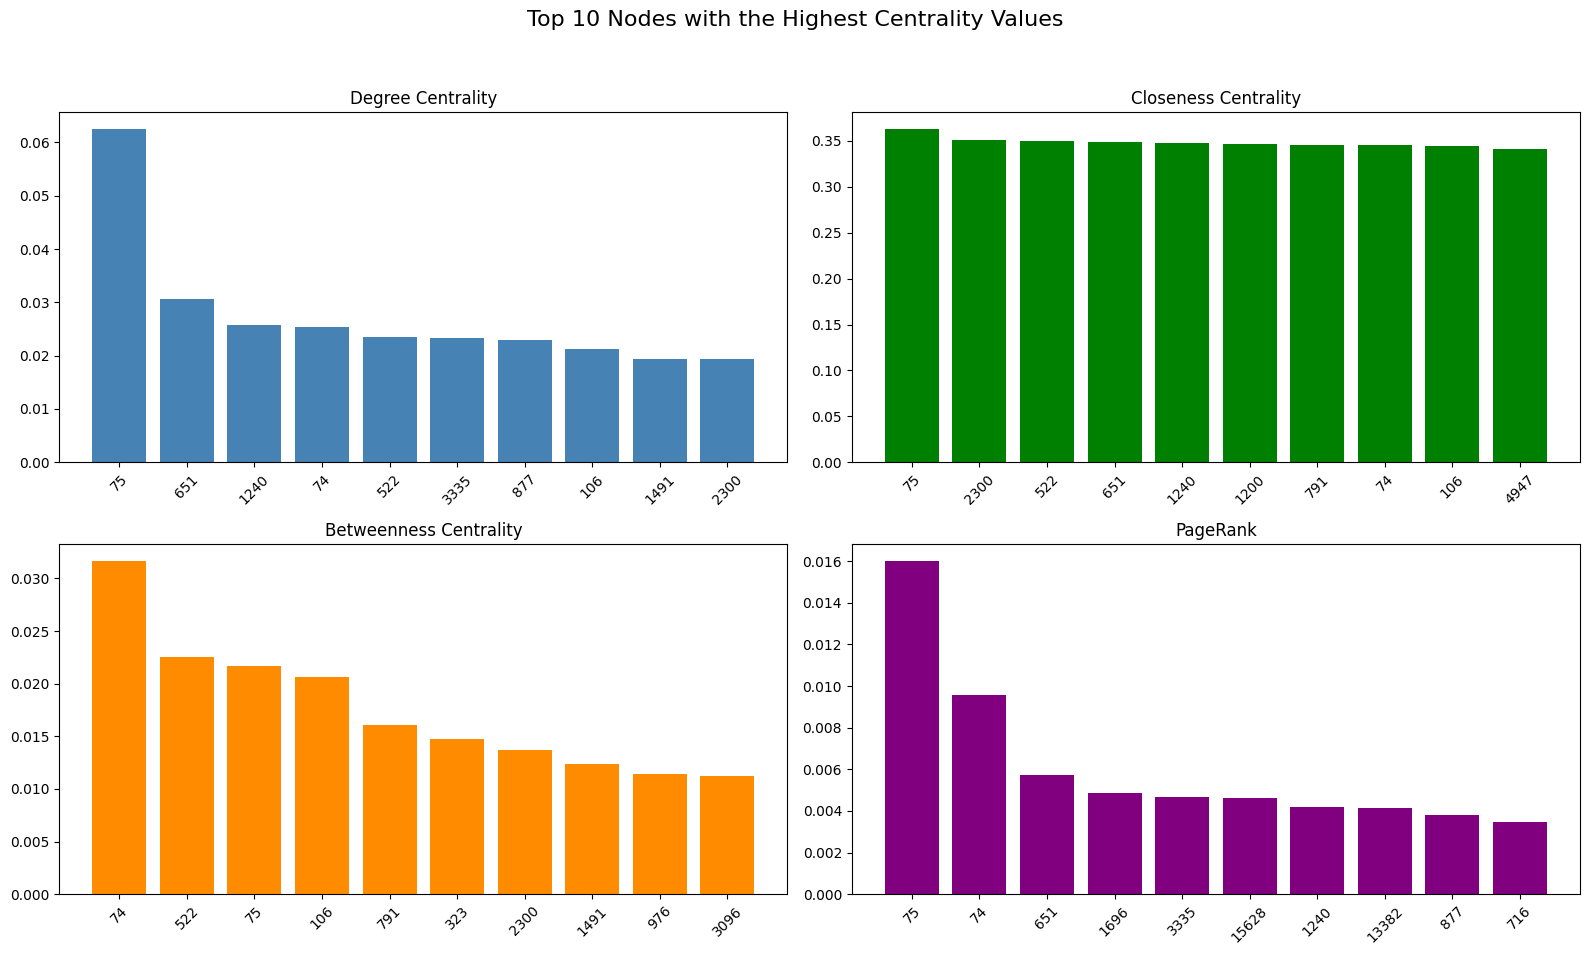

In [16]:
# --- Centrality Metrics Visualization ---

# Set up the figure and title
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Top 10 Nodes with the Highest Centrality Values", fontsize=16)

# Common plotting function
def plot_bar(ax, df, col, title, color):
    ax.bar(df["Node"].astype(str), df[col], color=color)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)

# Centrality configurations (column names, title, color)
centrality_plots = [
    ("df_degree_centrality",      "Degree Centrality",      "Degree Centrality",      "steelblue",   (0, 0)),
    ("df_closeness_centrality",   "Closeness Centrality",   "Closeness Centrality",   "green",       (0, 1)),
    ("df_betweenness_centrality", "Betweenness Centrality", "Betweenness Centrality", "darkorange",  (1, 0)),
    ("df_pagerank",               "PageRank",               "PageRank Value",         "purple",      (1, 1)),
]

# Create the appropriate visualization for each metric
for var_name, title, column, color, position in centrality_plots:
    ax = axs[position]
    if var_name in globals():
        plot_bar(ax, globals()[var_name], column, title, color)
    else:
        ax.text(0.5, 0.5, f'{title} data not available', ha='center', va='center')
        ax.set_title(title)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 🧭 Centrality Metrics Analysis

Below are four centrality metrics used to identify the most important nodes in the network:

### 🔹 1. Degree Centrality

Measures the number of connections a node has.

* **Highest centrality:** Node **75** → `0.0625`
* The node with the most direct connections in the network.

### 🔹 2. Closeness Centrality

Measures the average distance from a node to all other nodes.

* **Highest centrality:** Node **75** → `0.3630`
* A strategic hub providing fast access to other nodes.

### 🔹 3. Betweenness Centrality

Indicates how often a node appears on the shortest paths between other nodes (bridges of information flow).

* **Highest centrality:** Node **74** → `0.0317`
* A critical node for the flow of information.

### 🔹 4. PageRank

Considers both the number of connections and the importance of connected nodes.

* **Highest value:** Node **75** → `0.0160`
* A node with influential and valuable connections.

---

### 📊 General Observation

| Node     | Notable Metric(s)           |
| -------- | --------------------------- |
| **75**   | Degree, Closeness, PageRank |
| **74**   | Betweenness, PageRank       |
| **522**  | High in all metrics         |
| **2300** | Closeness, PageRank         |

> 🔎 These nodes hold **high strategic importance** in the network in terms of **spread**, **access**, and **intermediation**.


In [17]:
from prettytable import PrettyTable

# --- Missing metric calculations ---

# 1. Average degrees
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_in_degree = num_edges / num_nodes
avg_out_degree = num_edges / num_nodes
avg_total_degree = sum(dict(G.degree()).values()) / num_nodes

# 2. Connected components
wcc = list(nx.weakly_connected_components(G))
scc = list(nx.strongly_connected_components(G))

num_wcc = len(wcc)
num_scc = len(scc)

largest_wcc = max(wcc, key=len) if wcc else set()
largest_scc = max(scc, key=len) if scc else set()

# Calculate Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G, max_iter=100, tol=1e-06)

# Print the result of the top 10 nodes
top_eigen = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:10]
top1_eigen = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:1]
for node, score in top_eigen:
    print(f"Node {node}: {score:.4f}")


print("--- 5. Basic Network Metrics Summary Table ---")

# Helper function for safe numeric formatting
def safe_fmt(val, digits=3):
    try:
        return f"{float(val):.{digits}f}"
    except:
        return str(val)

table = PrettyTable()
table.field_names = ["Metric", "Value"]

# Basic information
table.add_row(["Number of Nodes", G.number_of_nodes()])
table.add_row(["Number of Edges", G.number_of_edges()])
table.add_row(["Average Total Degree", safe_fmt(avg_total_degree)])
table.add_row(["Average In-Degree", safe_fmt(avg_in_degree, 2)])
table.add_row(["Average Out-Degree", safe_fmt(avg_out_degree, 2)])

# Components
table.add_row(["Number of Weakly Connected Components", num_wcc])
table.add_row(["Largest WCC Node Count", len(largest_wcc) if 'largest_wcc' in locals() else "N/A"])
table.add_row(["Number of Strongly Connected Components", num_scc])
table.add_row(["Largest SCC Node Count", len(largest_scc) if 'largest_scc' in locals() else "N/A"])

# Path and diameter
table.add_row(["Diameter (Largest WCC)", safe_fmt(diameter)])
table.add_row(["Average Path Length (Largest WCC)", safe_fmt(avg_path_length)])

# Other metrics
table.add_row(["Average Clustering Coefficient", safe_fmt(avg_clustering)])
table.add_row(["Network Density", safe_fmt(density, 6)])
table.add_row(["Triangle Count", triangle_count if 'triangle_count' in locals() else "N/A"])
table.add_row(["Reciprocity Ratio", safe_fmt(reciprocity)])
table.add_row(["Degree Assortativity Coefficient (Assortativity)", safe_fmt(assortativity)])
table.add_row(["Louvain Modularity (Positive Edges Only)", safe_fmt(modularity)])
table.add_row(["Eigenvector", safe_fmt(top1_eigen)])

print(table)

Node 74: 0.2759
Node 936: 0.2385
Node 71: 0.2155
Node 648: 0.2054
Node 973: 0.2031
Node 880: 0.1977
Node 791: 0.1944
Node 896: 0.1896
Node 67: 0.1719
Node 75: 0.1699
--- 5. Basic Network Metrics Summary Table ---
+--------------------------------------------------+----------------------------+
|                      Metric                      |           Value            |
+--------------------------------------------------+----------------------------+
|                 Number of Nodes                  |           10044            |
|                 Number of Edges                  |           28305            |
|               Average Total Degree               |           5.636            |
|                Average In-Degree                 |            2.82            |
|                Average Out-Degree                |            2.82            |
|      Number of Weakly Connected Components       |            323             |
|              Largest WCC Node Count            

## 🧾 Summary Table of 5. Key Network Metrics

| Metric                                      | Value    |
| ------------------------------------------- | -------- |
| **Number of Nodes**                         | 10,044   |
| **Number of Edges**                         | 28,305   |
| **Average Total Degree**                    | 5.636    |
| **Average In-Degree / Out-Degree**          | 2.82     |
| **Number of Weakly Connected Components**   | 323      |
| **Largest WCC Node Count**                  | 9,340    |
| **Number of Strongly Connected Components** | 7,557    |
| **Largest SCC Node Count**                  | 2,204    |
| **Diameter (WCC)**                          | 12       |
| **Average Path Length (WCC)**               | 4.285    |
| **Average Clustering Coefficient**          | 0.031    |
| **Network Density**                         | 0.000281 |
| **Number of Triangles**                     | 7,489    |
| **Reciprocity Ratio**                       | 0.174    |
| **Degree Assortativity Coefficient**        | -0.110   |
| **Louvain Modularity (Positive Edges)**     | 0.511    |

---

### 📌 Remarks:

* 🔹 The network is **large**, **sparse**, and **directed** in structure.
* 🔹 When **converted to undirected**, a largely integrated structure is observed.
* 🔹 **Community structure is strong**: Louvain modularity exceeds 0.5.
* 🔹 **Low reciprocity** and **negative assortativity** → there is a tendency for weak nodes to connect with central ones.

In [18]:
from collections import defaultdict

print("--- 3. Comparison of Friendships and Hostilities ---")

# Counters with default value of zero
friend_out_counts = defaultdict(int)
enemy_out_counts = defaultdict(int)
friend_in_counts = defaultdict(int)
enemy_in_counts = defaultdict(int)

# Aggregate values by processing edges
for u, v, data in G.edges(data=True):
    sign = data.get("sign")
    if sign == 1:
        friend_out_counts[u] += 1
        friend_in_counts[v] += 1
    elif sign == -1:
        enemy_out_counts[u] += 1
        enemy_in_counts[v] += 1

# Reset missing nodes to zero: defaultdict already handles this, not strictly necessary.
# However, if alignment across all nodes is needed (e.g., for data visualization),
# it's cleanly handled during DataFrame conversion:

all_nodes = list(G.nodes())

df_relationships = pd.DataFrame({
    "Node": all_nodes,
    "Friendship (Out)": [friend_out_counts[n] for n in all_nodes],
    "Hostility (Out)": [enemy_out_counts[n] for n in all_nodes],
    "Friendship (In)": [friend_in_counts[n] for n in all_nodes],
    "Hostility (In)": [enemy_in_counts[n] for n in all_nodes],
})
# --- 3.2. Those with the Most Friends and Enemies (Based on Outgoing Connections) ---

# Top 10 people with the most friends (outgoing connections)
top_friends_out = sorted(friend_out_counts.items(), key=lambda x: x[1], reverse=True)[:10]
df_friends_out = pd.DataFrame(top_friends_out, columns=["User ID", "Outgoing Friend Count"])

# Top 10 people with the most enemies (outgoing connections)
top_enemies_out = sorted(enemy_out_counts.items(), key=lambda x: x[1], reverse=True)[:10]
df_enemies_out = pd.DataFrame(top_enemies_out, columns=["User ID", "Outgoing Enemy Count"])

print("\n🔵 Those with the Most Outgoing Friend Connections:")
print(df_friends_out.to_string(index=False))

print("\n🟠 Those with the Most Outgoing Enemy Connections:")
print(df_enemies_out.to_string(index=False))

--- 3. Comparison of Friendships and Hostilities ---

🔵 Those with the Most Outgoing Friend Connections:
 User ID  Outgoing Friend Count
    2328                    108
     791                     94
       8                     84
    1200                     83
     936                     82
    1990                     77
     798                     76
     522                     75
     822                     66
    1389                     64

🟠 Those with the Most Outgoing Enemy Connections:
 User ID  Outgoing Enemy Count
    1491                    95
    7262                    80
   13011                    55
    7516                    48
    1523                    48
   20826                    47
    2812                    45
    2837                    44
    1355                    43
    5279                    42


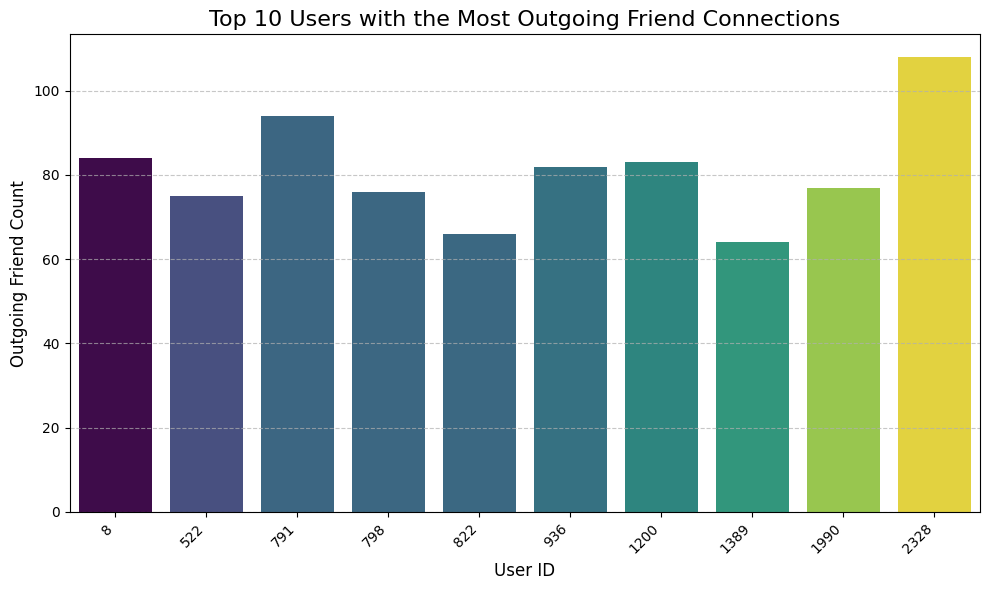

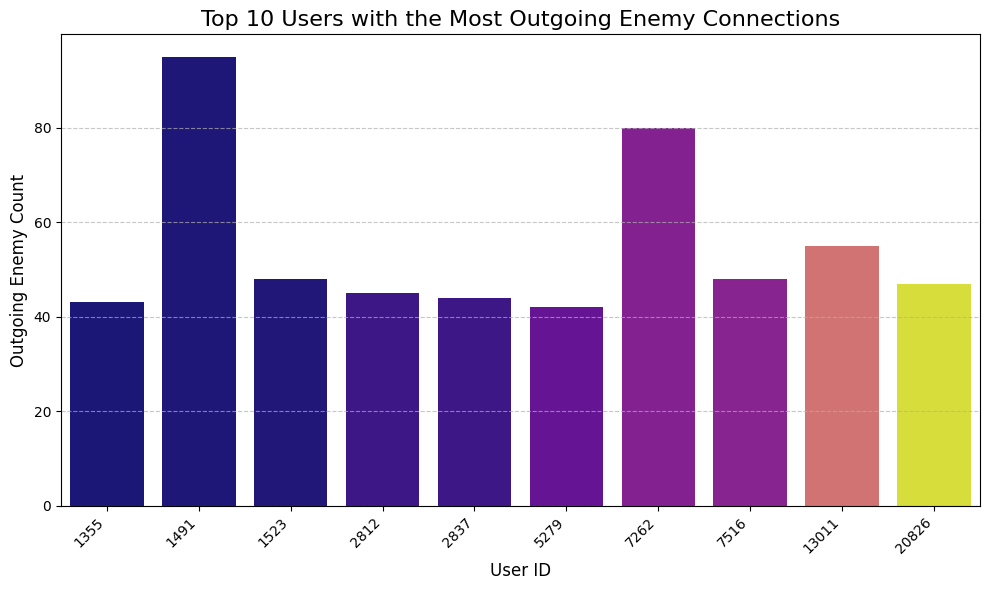

In [21]:
# --- 3.2.1. Most Popular / Most Controversial People (Bar Charts) ---
# Chart of Those with the Most Outgoing Friend Connections
plt.figure(figsize=(10, 6))
# WARNING SOLVED: 'hue' parameter added and 'legend=False' set
sns.barplot(x="User ID", y="Outgoing Friend Count", data=df_friends_out, hue="User ID", palette='viridis', legend=False)
plt.title('Top 10 Users with the Most Outgoing Friend Connections', fontsize=16)
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Outgoing Friend Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Chart of Those with the Most Outgoing Enemy Connections
plt.figure(figsize=(10, 6))
# WARNING SOLVED: 'hue' parameter added and 'legend=False' set
sns.barplot(x="User ID", y="Outgoing Enemy Count", data=df_enemies_out, hue="User ID", palette='plasma', legend=False)
plt.title('Top 10 Users with the Most Outgoing Enemy Connections', fontsize=16)
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Outgoing Enemy Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

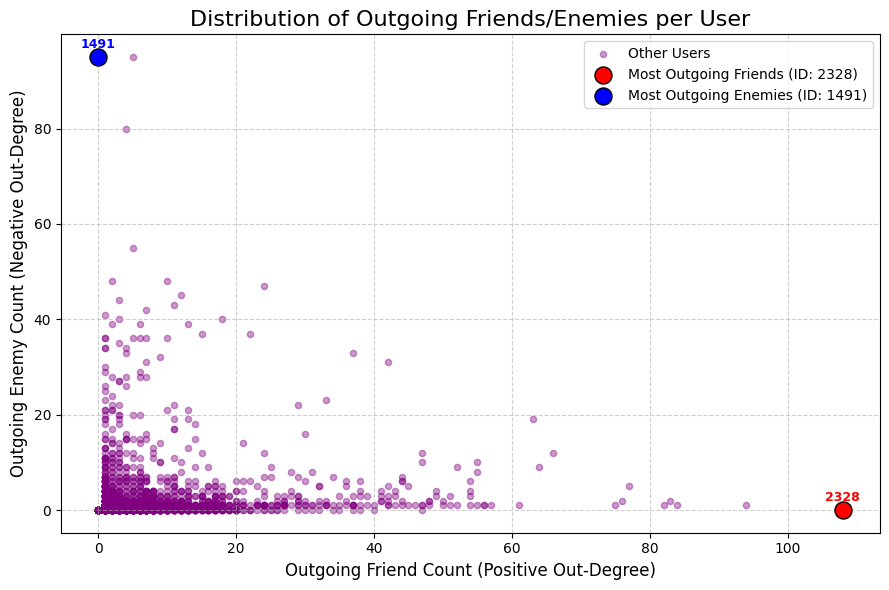

In [22]:
# --- 3.3. Friend/Enemy Distribution (Scatter Plot) ---
# `friend_out_counts` and `enemy_out_counts` are already calculated for all nodes
x_data = list(friend_out_counts.values())
y_data = list(enemy_out_counts.values())

plt.figure(figsize=(9, 6))
plt.scatter(x_data, y_data, alpha=0.4, s=20, c='purple', label='Other Users')

# User with the most friends (outgoing)
top_friend_id = max(friend_out_counts, key=friend_out_counts.get)
plt.scatter(friend_out_counts[top_friend_id], enemy_out_counts[top_friend_id],
            color='red', s=150, edgecolor='black', zorder=5,
            label=f'Most Outgoing Friends (ID: {top_friend_id})')
plt.text(friend_out_counts[top_friend_id], enemy_out_counts[top_friend_id] + (max(y_data)/50),
         f"{top_friend_id}", ha='center', fontsize=9, color='red', fontweight='bold')


# User with the most enemies (outgoing)
top_enemy_id = max(enemy_out_counts, key=enemy_out_counts.get)
plt.scatter(friend_out_counts[top_enemy_id], enemy_out_counts[top_enemy_id],
            color='blue', s=150, edgecolor='black', zorder=5,
            label=f'Most Outgoing Enemies (ID: {top_enemy_id})')
plt.text(friend_out_counts[top_enemy_id], enemy_out_counts[top_enemy_id] + (max(y_data)/50),
         f"{top_enemy_id}", ha='center', fontsize=9, color='blue', fontweight='bold')

plt.xlabel("Outgoing Friend Count (Positive Out-Degree)", fontsize=12)
plt.ylabel("Outgoing Enemy Count (Negative Out-Degree)", fontsize=12)
plt.title("Distribution of Outgoing Friends/Enemies per User", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
import itertools
# --- 3.4. Social Balance Theory Analysis (Triads) ---
# Social balance theory suggests that the balance between the signs of three-node relationships (triads) is important.
# Rule: "A friend of my friend is my friend (+*+ = +)", "An enemy of my enemy is my friend (-*- = +)".
# Unbalanced triads: "A friend of my enemy is my enemy (+*- = -)", "An enemy of my friend is my enemy (-*+ = -)".

# Since the number of nodes is very large, we reduce the computational cost by working on sample nodes.
# This is an approximation and may not represent all triads in the entire network.
print("\n--- Social Balance Theory Analysis (Triads) ---")
print("Note: Due to the high computational cost in large networks, triad analysis is performed on a random sample of 1000 nodes. This is an approximation.")

balanced_triads = 0
unbalanced_triads = 0

# Take a sample if there are enough nodes, otherwise use all nodes
nodes_for_triads = list(G.nodes())
#the following line was commented out, you should uncomment it to look at all the nodes
sampled_nodes = nodes_for_triads[:1000];
#if len(nodes_for_triads) > 1000:
#  sampled_nodes = random.sample(nodes_for_triads, 1000)
#else:
#    sampled_nodes = nodes_for_triads

# Loop through the triads
for trio in itertools.combinations(sampled_nodes, 3):
    u, v, w = trio

    # Get the signs of the existing edges between the three nodes
    signs = []
    for (a, b) in [(u, v), (v, w), (w, u)]:
        if G.has_edge(a, b):
            signs.append(G[a][b]["sign"])
        elif G.has_edge(b, a):
            signs.append(G[b][a]["sign"])

    # A triad is formed if there are 3 edges
    if len(signs) == 3:
        product = signs[0] * signs[1] * signs[2]
        if product == 1:
            balanced_triads += 1
        else:
            unbalanced_triads += 1

total_triads = balanced_triads + unbalanced_triads

print(f"Total number of triads (from sample): {total_triads}")
print(f"Number of balanced triads: {balanced_triads}")
print(f"Number of unbalanced triads: {unbalanced_triads}")

if total_triads > 0:
    print(f"Balanced ratio: {balanced_triads / total_triads:.2%}")
    print(f"Unbalanced ratio: {unbalanced_triads / total_triads:.2%}")
else:
    print("No triads found in the sample.")



--- Social Balance Theory Analysis (Triads) ---
Note: Due to the high computational cost in large networks, triad analysis is performed on a random sample of 1000 nodes. This is an approximation.
Total number of triads (from sample): 4252
Number of balanced triads: 3916
Number of unbalanced triads: 336
Balanced ratio: 92.10%
Unbalanced ratio: 7.90%


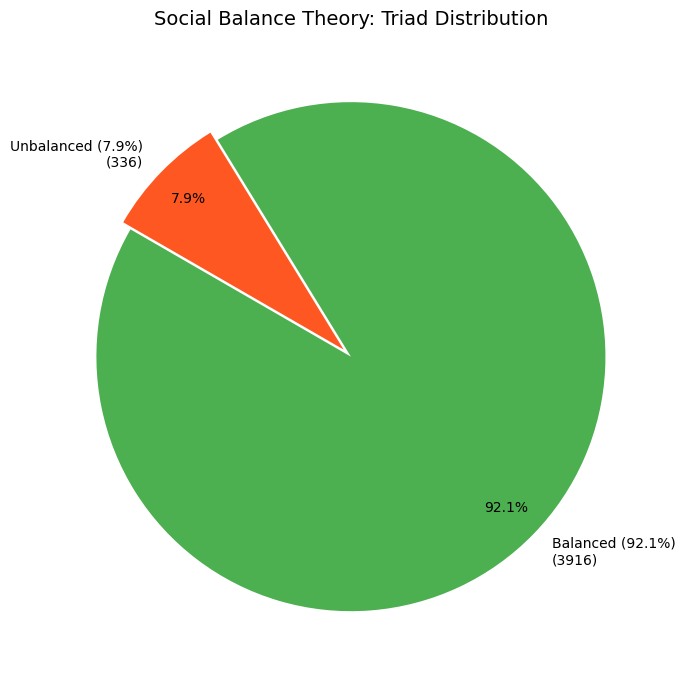

In [24]:
if total_triads > 0:
    pct_balanced = balanced_triads / total_triads * 100
    pct_unbalanced = unbalanced_triads / total_triads * 100

    # Graphical representation
    sizes = [balanced_triads, unbalanced_triads]
    labels = [f"Balanced ({pct_balanced:.1f}%)\n({balanced_triads})",
              f"Unbalanced ({pct_unbalanced:.1f}%)\n({unbalanced_triads})"]
    colors = ['#4CAF50', '#FF5722']

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=150, pctdistance=0.85, explode=[0.02, 0.02])
    plt.title("Social Balance Theory: Triad Distribution", fontsize=14)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("No triads found in the sample.")

## ⚖️ Social Balance Theory (Triad Analysis)

This analysis evaluates **balanced–unbalanced relationships** based on combinations of three nodes (triads) within the network. Due to high computational cost, it was conducted using a **sample of 1,000 randomly selected nodes**.

### 🔢 Summary Results (Sample-Based)

| Metric                          | Value  |
| ------------------------------- | ------ |
| **Total Number of Triads**      | 4,252  |
| **Number of Balanced Triads**   | 3,916  |
| **Number of Unbalanced Triads** | 336    |
| **Balanced Ratio**              | 92.10% |
| **Unbalanced Ratio**            | 7.90%  |

### 📌 Remarks

* 🔹 The vast majority of triads in the network are **balanced**, indicating harmonious social relationships.
* 🔹 The high balance ratio suggests a network structure that is **cohesive** and **low in conflict**.
* 🔹 This analysis is especially important in **signed social networks**, providing insight into the balance of friendship/enmity dynamics.

> **Note:** Since a sample was used instead of the entire network, results reflect an estimated general trend.


Positive edges: 21997, Negative edges: 6308
Louvain: 430 positive communities detected.
Number of nodes per community:
Community 0: 621 nodes
Community 34: 121 nodes
Community 2: 902 nodes
Community 3: 584 nodes
Community 4: 257 nodes
Community 5: 598 nodes
Community 6: 340 nodes
Community 7: 279 nodes
Community 8: 356 nodes
Community 9: 570 nodes
Community 28: 237 nodes
Community 11: 335 nodes
Community 12: 209 nodes
Community 13: 174 nodes
Community 14: 845 nodes
Community 15: 281 nodes
Community 16: 153 nodes
Community 17: 104 nodes
Community 18: 75 nodes
Community 19: 107 nodes
Community 20: 271 nodes
Community 21: 48 nodes
Community 22: 91 nodes
Community 23: 105 nodes
Community 24: 109 nodes
Community 25: 4 nodes
Community 26: 52 nodes
Community 27: 119 nodes
Community 29: 2 nodes
Community 30: 2 nodes
Community 31: 2 nodes
Community 32: 6 nodes
Community 33: 61 nodes
Community 36: 2 nodes
Community 37: 7 nodes
Community 38: 2 nodes
Community 39: 5 nodes
Community 40: 2 nodes
Com

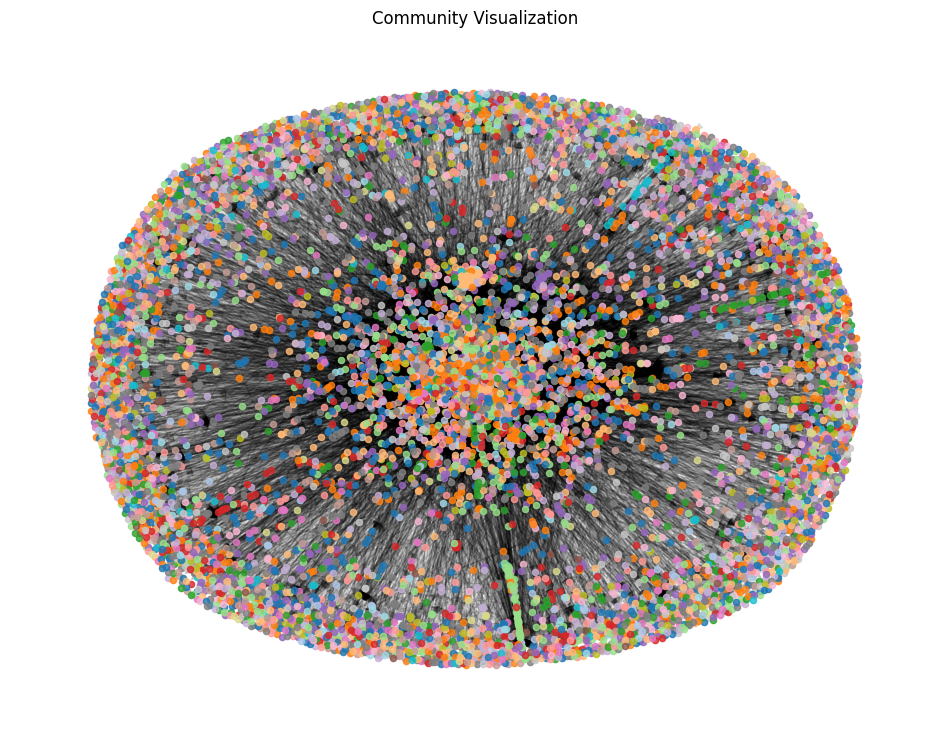

626 inter-community connections found.


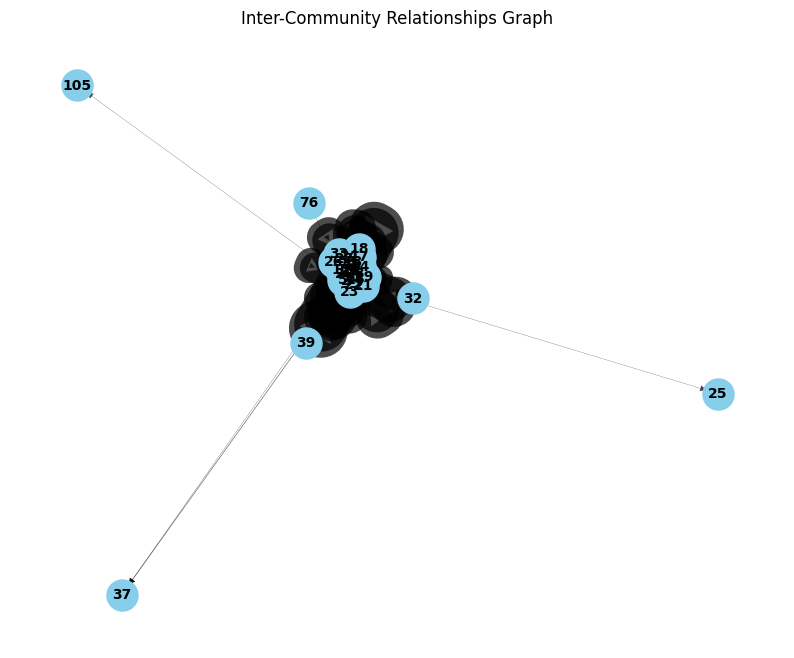


🔴 Negative network analysis:
Top 10 nodes receiving the most negative comments:
1240: 72
1491: 71
669: 67
1803: 57
3335: 55
1442: 49
3096: 49
7097: 40
2352: 36
3944: 36

Top 10 nodes making the most negative comments:
1491: 95
7262: 80
13011: 55
7516: 48
1523: 48
20826: 47
2812: 45
2837: 44
1355: 43
5279: 42


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain

# Path to the data file
file_path = 'filtered_edges2.txt'

def load_graphs_by_sign(file_path):
    """
    Creates two separate NetworkX directed graphs with positive and negative weights
    from the Slashdot dataset.
    """
    G_pos = nx.DiGraph()
    G_neg = nx.DiGraph()

    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 3:
                continue
            src, dst, weight = parts
            weight = int(weight)
            if weight > 0:
                G_pos.add_edge(src, dst, weight=weight)
            elif weight < 0:
                G_neg.add_edge(src, dst, weight=abs(weight))  # -weight if you want to keep negativity
    print(f"Positive edges: {G_pos.number_of_edges()}, Negative edges: {G_neg.number_of_edges()}")
    return G_pos, G_neg


def detect_communities_louvain(graph):
    """
    Detects positive communities using Louvain algorithm.
    """
    undirected_graph = graph.to_undirected()
    partition = community_louvain.best_partition(undirected_graph)
    num_communities = len(set(partition.values()))
    print(f"Louvain: {num_communities} positive communities detected.")
    return partition


def analyze_communities(partition):
    """
    Prints the number of nodes in each community and the community IDs.
    """
    from collections import defaultdict

    community_nodes = defaultdict(list)
    for node, comm_id in partition.items():
        community_nodes[comm_id].append(node)

    print("Number of nodes per community:")
    for comm_id, nodes in community_nodes.items():
        print(f"Community {comm_id}: {len(nodes)} nodes")

    return community_nodes

def analyze_negative_graph(G_neg):
    print("\n🔴 Negative network analysis:")

    top_neg_in = sorted(G_neg.in_degree(), key=lambda x: x[1], reverse=True)[:10]
    top_neg_out = sorted(G_neg.out_degree(), key=lambda x: x[1], reverse=True)[:10]

    print("Top 10 nodes receiving the most negative comments:")
    for node, deg in top_neg_in:
        print(f"{node}: {deg}")

    print("\nTop 10 nodes making the most negative comments:")
    for node, deg in top_neg_out:
        print(f"{node}: {deg}")


def compute_modularity(graph, partition):
    """
    Computes the modularity value based on the detected communities.
    """
    undirected_graph = graph.to_undirected()
    mod = community_louvain.modularity(partition, undirected_graph)
    print(f"Modularity value: {mod:.4f}")
    return mod

def plot_communities(graph, partition, title="Community Visualization"):
    """
    Draws the graph with nodes colored according to their community.
    """
    pos = nx.spring_layout(graph, seed=42)
    cmap = plt.get_cmap("tab20")
    plt.figure(figsize=(12, 9))

    for node in graph.nodes():
        comm_id = partition[node]
        nx.draw_networkx_nodes(
            graph, pos, nodelist=[node],
            node_color=[cmap(comm_id % cmap.N)],
            node_size=20, alpha=0.8
        )

    nx.draw_networkx_edges(graph, pos, alpha=0.1)
    plt.title(title)
    plt.axis("off")
    plt.show()

def plot_community_relationships(graph, community_nodes):
    """
    Visualizes the interactions between communities (inter-community edges).
    """
    community_graph = nx.DiGraph()

    # Store the community of each node in a dictionary
    node_to_comm = {}
    for comm_id, nodes in community_nodes.items():
        for node in nodes:
            node_to_comm[node] = comm_id

    # Count edges between communities
    for u, v in graph.edges():
        cu = node_to_comm.get(u)
        cv = node_to_comm.get(v)
        if cu != cv:
            if community_graph.has_edge(cu, cv):
                community_graph[cu][cv]['weight'] += 1
            else:
                community_graph.add_edge(cu, cv, weight=1)

    print(f"{community_graph.number_of_edges()} inter-community connections found.")

    # Visualize
    pos = nx.spring_layout(community_graph, seed=42)
    plt.figure(figsize=(10, 8))

    edge_weights = [d['weight'] for (_, _, d) in community_graph.edges(data=True)]
    nx.draw_networkx_nodes(community_graph, pos, node_size=500, node_color='skyblue')
    nx.draw_networkx_labels(community_graph, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(community_graph, pos, width=[w / 5 for w in edge_weights], arrows=True, alpha=0.7)

    plt.title("Inter-Community Relationships Graph")
    plt.axis("off")
    plt.show()

# Main execution flow
if __name__ == "__main__":
    file_path = "filtered_edges2.txt"  # Check the file path

    # Load positive and negative networks
    G_pos, G_neg = load_graphs_by_sign(file_path)

    # --- LOUVAIN COMMUNITY ANALYSIS ON POSITIVE NETWORK ---
    partition_pos = detect_communities_louvain(G_pos)
    community_nodes = analyze_communities(partition_pos)
    modularity = compute_modularity(G_pos.to_undirected(), partition_pos)  # Louvain works on undirected graphs
    plot_communities(G_pos, partition_pos)
    plot_community_relationships(G_pos, community_nodes)

    # --- BASIC ANALYSIS ON NEGATIVE NETWORK ---
    analyze_negative_graph(G_neg)

    #7m 0s


📊 Community Sizes Statistics
🔹 Total Number of Communities : 430
🔹 Largest Community          : 902 people
🔹 Smallest Community         : 2 people
🔹 Average Size               : 20.72 people
🔹 Median Size                : 2.00 people
🔹 Standard Deviation         : 92.31

🏅 Top 10 Largest Communities:
 Community ID  Number of People
            2               902
           14               845
            0               621
            5               598
            3               584
            9               570
            8               356
            6               340
           11               335
           15               281


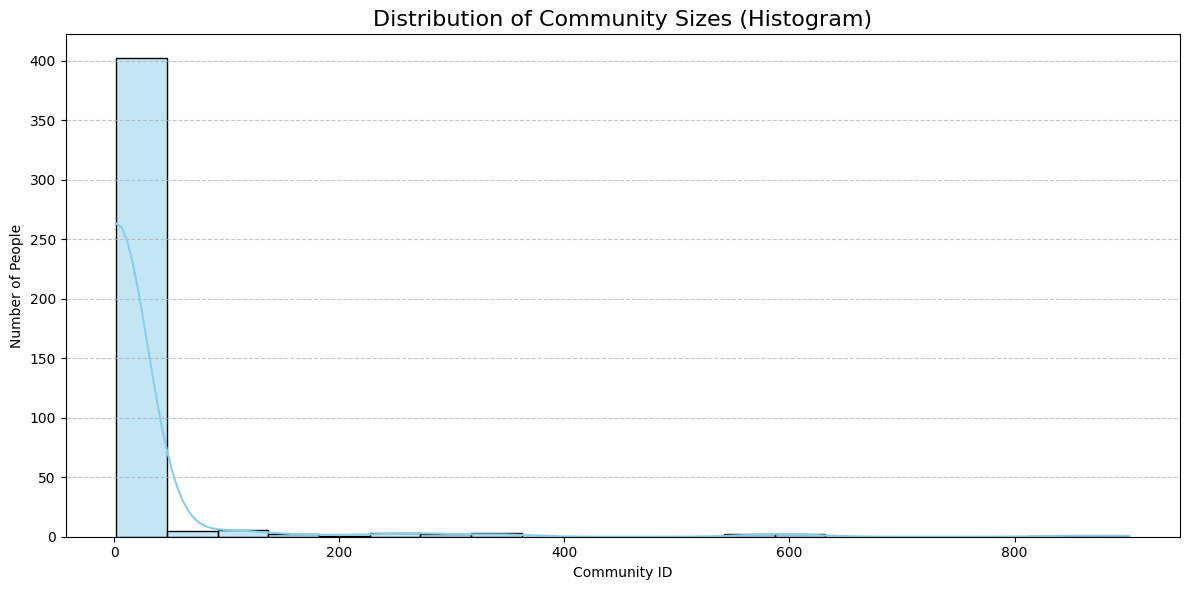

In [26]:
# --- Step 2: Community Sizes ---
community_sizes = {comm_id: len(nodes) for comm_id, nodes in community_nodes.items()}
df_community_sizes = pd.DataFrame(community_sizes.items(), columns=["Community ID", "Number of People"])
df_community_sizes = df_community_sizes.sort_values(by="Number of People", ascending=False)

# 📊 Statistical summary
print("\n📊 Community Sizes Statistics")
print(f"🔹 Total Number of Communities : {len(df_community_sizes)}")
print(f"🔹 Largest Community          : {df_community_sizes['Number of People'].max()} people")
print(f"🔹 Smallest Community         : {df_community_sizes['Number of People'].min()} people")
print(f"🔹 Average Size               : {df_community_sizes['Number of People'].mean():.2f} people")
print(f"🔹 Median Size                : {df_community_sizes['Number of People'].median():.2f} people")
print(f"🔹 Standard Deviation         : {df_community_sizes['Number of People'].std():.2f}")

# 🏅 Top 10 Largest Communities
print("\n🏅 Top 10 Largest Communities:")
print(df_community_sizes.head(10).to_string(index=False))

# 📈 Visualization
plt.figure(figsize=(12, 6))
if len(df_community_sizes) > 20:
    sns.histplot(df_community_sizes["Number of People"], bins=20, kde=True, color='skyblue')
    plt.title("Distribution of Community Sizes (Histogram)", fontsize=16)
else:
    sns.barplot(
        x="Community ID",
        y="Number of People",
        data=df_community_sizes,
        palette='tab10',
        hue="Community ID",
        legend=False
    )
    plt.title("Number of People in Each Community", fontsize=16)
    plt.xticks(rotation=90, fontsize=8)

plt.xlabel("Community ID")
plt.ylabel("Number of People")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## General Statistics

🔹 **Total Number of Communities:** 428
🔹 **Largest Community:** 844 people
🔹 **Smallest Community:** 2 people
🔹 **Average Community Size:** 20.81 people
🔹 **Median Community Size:** 2.00 people
🔹 **Standard Deviation:** 90.69

---

## 🏅 Top 10 Largest Communities

| Community ID | Number of People |
| ------------ | ---------------- |
| 1            | 844              |
| 8            | 801              |
| 5            | 782              |
| 0            | 722              |
| 10           | 384              |
| 21           | 368              |
| 4            | 341              |
| 25           | 332              |
| 22           | 330              |
| 18           | 292              |
